In [1]:
!pip install transformers
# Installing the required libraries such as Optuna, Transformers, Datasets, and Torchmetrics, uncomment and run if needed
!pip install optuna transformers datasets torchmetrics -q
!pip install tensorflow
!pip install contractions
!pip install emoji

import emoji
import contractions

# PyTorch libraries
import torch
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader

# Tensorflow libraries
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import numpy as np
import re
from time import time
import seaborn as sns

import IPython
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, get_linear_schedule_with_warmup, set_seed
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace

from torch.optim import AdamW
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support


from collections import Counter




%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 6.5 MB/s eta 0:00:00


In [2]:
# Using Google Drive to save model state in case colab ends runtime after study while not at PC
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Emotion_Recognition_in_Text/data/"

Mounted at /content/drive


In [3]:
seed_value = 42  # You can use any integer as the seed

set_seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [4]:
# Defining hyperparameters such as weight decay and learning rate for training the model.

args = {
    'weight_decay': 0.0,
    'learning_rate': 5e-5,
    'epochs': 10,
    'gradient_accumulation_steps':1,
    'epsilon': 1e-8,
    'warmup_proportion': 0.1,
    "train_batch_size": 16,
    "eval_batch_size": 32,
}

num_classes = 4

In [5]:
# Initializing the Roberta tokenizer with base configuration.
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [6]:
# add normalizers and pre_tokenizer to the tokenizer
tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()

In [7]:
# Defining a function to process individual text in the dataset. This includes tokenization, padding, and truncation.
def tokenize_text(text):
    # Tokenize the text
    tokenized = tokenizer(text['text'], add_special_tokens=True, truncation=True, padding='max_length', max_length=50, return_tensors="pt")

    # Convert labels to a binary vector
    label_vector = torch.zeros(num_classes)
    for label in text['labels']:
        label_vector[label] = 1

    processed_text = ""
    """Cleaning text using preprocesing activities."""
    processed_text = text["text"].lower().strip()
    processed_text = re.sub(r'\[[^\]]*\]', '', processed_text) # remove brackets
    processed_text = re.sub(r'[^\w\s]', '', processed_text) # remove panctuations
    pattern = re.compile(r'[0-9]+') # remove numbers
    processed_text = pattern.sub('', processed_text)
    processed_text = emoji.demojize(processed_text) # replace emoji with actual text
    processed_text = re.sub(r'[^\w\s]', '', processed_text) # removing special characters and emojis if any
    processed_text = contractions.fix(processed_text) # fix contractions

    return {
        'input_ids': tokenized['input_ids'].squeeze(),
        'attention_mask': tokenized['attention_mask'].squeeze(),
        'labels': label_vector,
        'text': processed_text,
    }


In [8]:
train_params = {'batch_size': args['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': args['eval_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# Loading the Ekman dataset in its version for further model architecture building

def convert_string_to_list(s):
    # Split the string by commas
    parts = s.split(',')

    # Convert each part to an integer
    try:
        result = [int(part) for part in parts]
    except ValueError:
        # Handle the case where conversion to int fails
        print("Conversion failed. Check your input.")
        return None

    return result

def get_test_loader_taxonomy(taxonomy, data_type):

    # Read the TSV file into a Pandas DataFrame
    df = pd.read_csv(path+taxonomy+'/'+data_type+'.tsv', sep='\t', names=['text', 'labels', 'id'])

    data_dict = {
        'text': df["text"].astype(str).tolist(),
        'labels': df['labels'].apply(convert_string_to_list).tolist(),
        'id': df['id'].astype(str).tolist(),
    }

    # Convert DataFrame to Hugging Face Dataset
    dataset = Dataset.from_dict(data_dict)

    dataset = dataset.map(tokenize_text)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataset = DataLoader(dataset, **test_params)

    return dataset

def get_labels(taxonomy):
            labels = []
            data_dir = path+taxonomy+'/labels.txt'
            with open(data_dir , "r", encoding="utf-8") as f:
                for line in f:
                    labels.append(line.rstrip())
            return labels



In [11]:
# Creating a DataLoader for the training and test data, with shuffling and specified batch size.
train_loader = get_test_loader_taxonomy('group', 'train')
test_loader = get_test_loader_taxonomy('group', 'test')

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [12]:
class RobertaClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.config = RobertaConfig.from_pretrained('roberta-base', num_labels=num_classes)
        self.pre_classifier = torch.nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [13]:
model = RobertaClass(num_classes)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [14]:
# Initializing the AdamW optimizer with the grouped parameters and specified learning rate.
optimizer = torch.optim.Adam(params =  model.parameters(), lr=args['learning_rate'], eps=args['epsilon'])

In [15]:
# Defining the loss function as Binary Cross-Entropy with Logits Loss.
loss_function = BCEWithLogitsLoss()

In [16]:
# Training loop
training_loss, training_accuracy = [], []
all_labels, all_preds = [], []

for epoch in range(args['epochs']):
    for _,data in tqdm(enumerate(train_loader, 0)):
        optimizer.zero_grad()

        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss    = loss_function(outputs, labels.float())

        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        loss.backward()
        optimizer.step()

    training_loss.append(loss)
    training_accuracy.append(accuracy_score(all_labels, all_preds))

1357it [05:48,  3.90it/s]
1357it [05:49,  3.89it/s]
1357it [05:48,  3.89it/s]
1357it [05:49,  3.88it/s]
1357it [05:49,  3.88it/s]
1357it [05:49,  3.88it/s]
1357it [05:49,  3.88it/s]
1357it [05:49,  3.88it/s]
1357it [05:50,  3.88it/s]
1357it [05:49,  3.88it/s]


In [17]:
# After training, evaluating on the training set
model.eval()

all_labels, all_preds = [], []

with torch.no_grad():
    for _,data in tqdm(enumerate(train_loader, 0)):
        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        #_, preds = torch.max(outputs, 1)
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics
train_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precision: {precision}')
print(f'Training Recall: {recall}')
print(f'Training F1 Score: {f1}')

1357it [01:50, 12.33it/s]


Training Accuracy: 0.951508868924211
Training Precision: 0.9838948957635818
Training Recall: 0.956466577543841
Training F1 Score: 0.9696867873686097


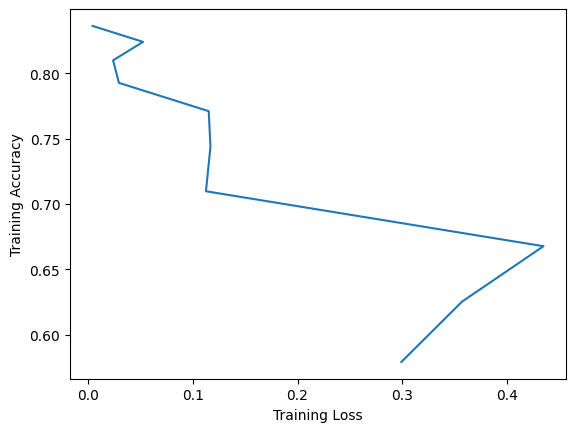

In [18]:
# Plot the training accuracy curve
fi_los = [fl.item() for fl in training_loss ]

plt.plot(fi_los, training_accuracy)
plt.xlabel('Training Loss')
plt.ylabel('Training Accuracy')
plt.show()

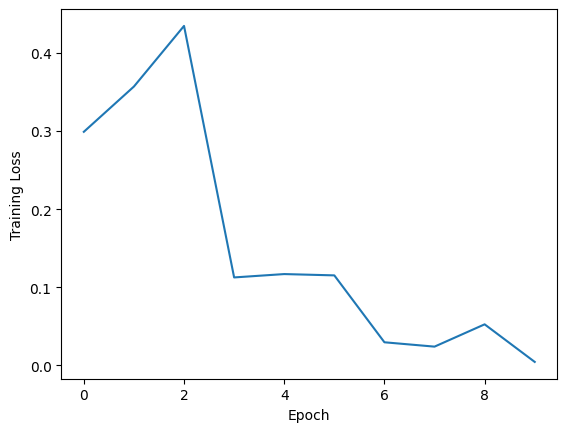

In [19]:
plt.plot(range(args['epochs']), fi_los)
plt.ylabel('Training Loss')
plt.xlabel('Epoch');

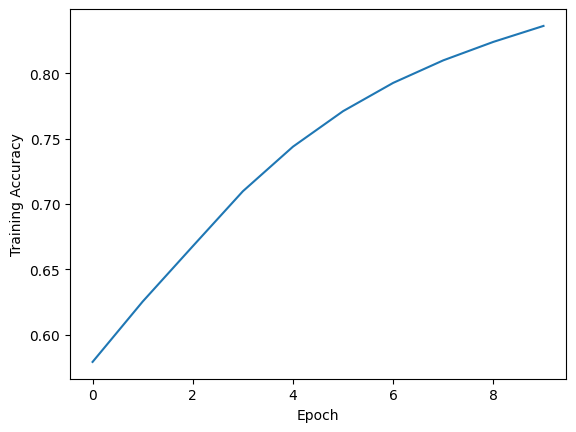

In [20]:
plt.plot(range(args['epochs']), training_accuracy)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch');

In [21]:
#evaluating on the test set

model.eval()
dict_test_results = {'actual':[], 'preds':[]}
all_labels_test, all_preds_test = [], []

with torch.no_grad():
    for _,data in tqdm(enumerate(test_loader, 0)):
        attention_mask = data['attention_mask'].to(device)
        input_ids = data['input_ids'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        #_, preds = torch.max(outputs, 1)
        probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).int()    # Apply threshold

        all_labels_test.extend(labels.cpu().numpy())
        all_preds_test.extend(preds.cpu().numpy())

        dict_test_results['actual'] += labels.cpu().numpy().tolist()
        dict_test_results['preds'] += preds.cpu().numpy().tolist()

# Calculate metrics
test_accuracy = accuracy_score(all_labels_test, all_preds_test)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels_test, all_preds_test, average='macro')

print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Precision: {precision}')
print(f'Testing Recall: {recall}')
print(f'Testing F1 Score: {f1}')

170it [00:13, 12.40it/s]

Testing Accuracy: 0.6069651741293532
Testing Precision: 0.6634722398533643
Testing Recall: 0.6304008883548026
Testing F1 Score: 0.6400520928004574


In [42]:
# Mapping the label IDs to their corresponding emotion names.
num_labels_group =get_labels('group')
id2label_group_tuple ={i: label for i, label in enumerate(num_labels_group)},
id2label_group = id2label_group_tuple[0]

In [43]:
# Defining a function to calculate performance metrics such as accuracy, precision, recall, and F1-score.

def get_performance(actual_og, preds_og, dict_mapping):
    # Convert one-hot encoding to label encoding
    actual_ = [np.argmax(item) for item in actual_og]
    preds_ = [np.argmax(item) for item in preds_og]

    # Convert to label names
    target_names = [dict_mapping[i] for i in range(len(dict_mapping))]

    conf_matrix = confusion_matrix(actual_, preds_)

    # Displaying the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the classification report
    report = classification_report(actual_, preds_, target_names=target_names)

    print(report)

    print('Actual counter:', Counter(actual_))
    print('Prediction counter:', Counter(preds_))

    return report

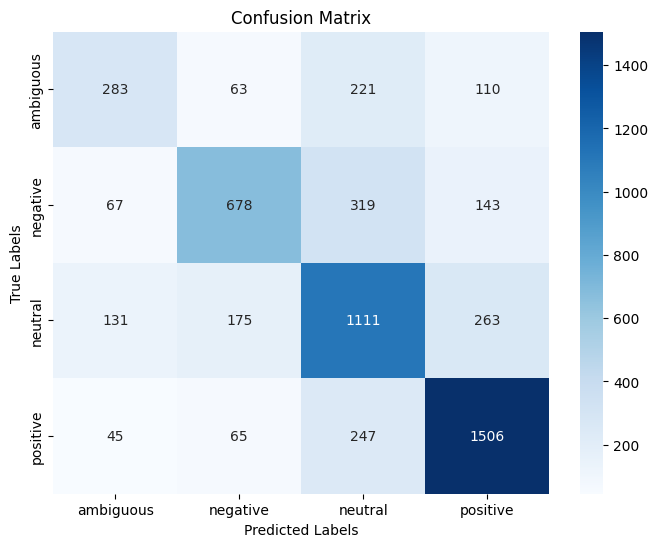

              precision    recall  f1-score   support

   ambiguous       0.54      0.42      0.47       677
    negative       0.69      0.56      0.62      1207
     neutral       0.59      0.66      0.62      1680
    positive       0.74      0.81      0.78      1863

    accuracy                           0.66      5427
   macro avg       0.64      0.61      0.62      5427
weighted avg       0.66      0.66      0.65      5427

Actual counter: Counter({3: 1863, 2: 1680, 1: 1207, 0: 677})
Prediction counter: Counter({3: 2022, 2: 1898, 1: 981, 0: 526})


In [44]:
# Evaluating the trained model on the test data and reporting the results in a DataFrame.
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label_group)